In [3]:
import os
from PIL import Image
import glob
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
import librosa
import scipy
import pywt
from random import shuffle
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("/home/suresh/maulik/vag/venv/lib/python3.10/site-packages")
print(sys.path)

['/home/suresh/maulik/vag', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/suresh/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/home/suresh/maulik/vag/venv/lib/python3.10/site-packages']


In [ ]:
import sys

# Add the path you want to remove
path_to_remove = "/home/suresh/maulik/vag/venv/lib/python3.10/site-packages"

# Check if the path is in sys.path before removing
if path_to_remove in sys.path:
    sys.path.remove(path_to_remove)
    print(f"Removed '{path_to_remove}' from sys.path")
else:
    print(f"'{path_to_remove}' is not in sys.path")


In [ ]:
!pip show librosa

# Transformations

### Short Time Fourier Transform (STFT)  

Librosa is a Python library for analyzing audio and music. It provides a wide range of functionality for tasks such as loading audio files, extracting features from audio signals, and performing various audio processing tasks. Librosa is widely used in fields such as music information retrieval, audio analysis, and machine learning.

In [4]:
def stft_signal(file_name, n_fft=256):

    y = np.loadtxt(file_name)
    D = librosa.stft(y, n_fft=n_fft)
    S, phase = librosa.magphase(D)
    S_p = np.log1p(S)/10.0
    X = np.stack([S_p,S_p,S_p],axis=2)
    return X

### Continuous Wavelet Transform (CWT)  
SciPy is a Python library that builds upon the capabilities of NumPy and provides a wide range of numerical algorithms and tools for scientific and technical computing. It is one of the core packages used for scientific computing in Python alongside NumPy, Matplotlib, and pandas.

In [5]:
import numpy as np
from scipy.signal import cwt
from scipy.signal.wavelets import morlet

def cwt_signal(file_name, widths=np.arange(1, 31)):

    y = np.loadtxt(file_name)
    coefficients = cwt(y, morlet, widths)  
    S_p = np.log1p(np.abs(coefficients)) / 10.0
    X = np.stack([S_p, S_p, S_p], axis=2)

    return X


/tmp/ipykernel_1545507/556940505.py:3: DeprecationWarning: Please use `morlet` from the `scipy.signal` namespace, the `scipy.signal.wavelets` namespace is deprecated.
  from scipy.signal.wavelets import morlet


### Discrete Wavelet Transform (DWT)  
The pywt library in Python is a powerful and widely-used package for wavelet analysis. It provides tools for performing various wavelet transforms, including the Continuous Wavelet Transform (CWT), the Discrete Wavelet Transform (DWT), and the Stationary Wavelet Transform (SWT). These transforms are commonly used in signal and image processing for tasks such as denoising, compression, feature extraction, and time-frequency analysis.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

def dwt_signal(file_name, wavelet='db4', level=5):
    y = np.loadtxt(file_name)
    coefficients = pywt.wavedec(y, wavelet, level=level)
    concatenated_coeffs = np.concatenate(coefficients)
    S_p = np.log1p(np.abs(concatenated_coeffs)) / 10.0

    # Reshape the coefficients into an image-like format
    num_frames = len(concatenated_coeffs)  # Total number of coefficients
    X = S_p.reshape((1, num_frames))  # Reshape to (1, num_frames)

    # Stack S_p along the third dimension to match the format of stft_signal
    X = np.stack([X, X, X], axis=2)

    return X



### TFD using non-seperable kernel

### TFD using Seperable Kernel

### TFD using Doppler Independent Kernel

### TFD using Lag-Independent Kernel

# Perform Transformation on vag signals

In [53]:
norm_dict = {
'normalize_torch' : transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
),
'normalize_05' : transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
)
}


class Read_dataset(Dataset):

    def __init__(self, folder_name,normalize_fun, img_size,val = False):

        labels = sorted(['abvag', 'novag'])
        print(labels)
        num_label = np.array(range(0,len(labels)))

        d_val = []
        l_val = []
        d_train = []
        l_train = []
        # print(labels)

        for index,name in zip(num_label,labels):
            x = folder_name+name+'/'+name+'*'
            print(x)
            img_list = glob.glob(folder_name+name+'/'+name+'*')
            shuffle(img_list)
            count = 0
            for i in img_list:
                if (count%3==0):
                    d_val.append(i)
                    l_val.append(index)
                else:
                    d_train.append(i)
                    l_train.append(index)

                count+=1


        if(val):
            self.data = d_val
            self.label = l_val

        else:
            self.data = d_train
            self.label = l_train


        self.transform = transforms.Compose([

            transforms.Resize((img_size,img_size), interpolation=2),
            transforms.ToTensor(),
            norm_dict[normalize_fun]
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):

        path, label = self.data[i], self.label[i]
        arr = np.uint8(dwt_signal(path)*255)
        image = self.transform(Image.fromarray(arr))
        return image, label



### *Dataset creation function for transformed images (using matlab)*

In [24]:
import os
import random
import glob
from PIL import Image
import numpy as np
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class ReadDatasetImages(Dataset):
    def __init__(self, folder_name, normalize_fun, img_size, val=False):
        folder_name = os.path.join(folder_name, "k1")

        labels = sorted(['abvag', 'novag'])
        num_label = np.arange(len(labels))

        d_val = []
        l_val = []
        d_train = []
        l_train = []

        for index, name in zip(num_label, labels):
            img_list = glob.glob(os.path.join(folder_name, name, name + '*'))
            random.shuffle(img_list)
            for i, img_path in enumerate(img_list):
                if (i % 3 == 0):
                    d_val.append(img_path)
                    l_val.append(index)
                else:
                    d_train.append(img_path)
                    l_train.append(index)

        if val:
            self.data = d_val
            self.labels = l_val
        else:
            self.data = d_train
            self.labels = l_train

        self.transform = transforms.Compose([

            transforms.Resize((img_size,img_size), interpolation=2),
            transforms.ToTensor(),
            norm_dict[normalize_fun]
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        IMG=Image.open(img_path)
        arr = np.array(IMG)
        arr = np.uint8(arr*255)
        image = self.transform(Image.fromarray(arr))


        return image, label


In [36]:
from functools import partial

from torch import nn
import torchvision.models as M
import pretrainedmodels

resnet18 = M.resnet18
resnet34 = M.resnet34
resnet50 = M.resnet50
resnet101 = M.resnet101
resnet152 = M.resnet152
vgg16 = M.vgg16
vgg16_bn = M.vgg16_bn
densenet121 = M.densenet121
densenet161 = M.densenet161
densenet201 = M.densenet201


class ResNetFinetune(nn.Module):
    finetune = True

    def __init__(self, num_classes, net_cls=M.resnet50, dropout=False):
        super(ResNetFinetune, self).__init__()
        self.net = net_cls(pretrained=True)
        if dropout:
            self.net.fc = nn.Sequential(
                nn.Dropout(),
                nn.Linear(self.net.fc.in_features, num_classes),
            )
        else:
            self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)

    def fresh_params(self):
        return self.net.fc.parameters()

    def forward(self, x):
        return self.net(x)


class DenseNetFinetune(nn.Module):
    finetune = True

    def __init__(self, num_classes, net_cls=M.densenet121):
        super(DenseNetFinetune, self).__init__()
        self.net = net_cls(pretrained=True)
        self.net.classifier = nn.Linear(self.net.classifier.in_features, num_classes)

    def fresh_params(self):
        return self.net.classifier.parameters()

    def forward(self, x):
        return self.net(x)


class InceptionV3Finetune(nn.Module):
    finetune = True

    def __init__(self, num_classes):
        super(InceptionV3Finetune, self).__init__()
        self.net = M.inception_v3(pretrained=True)
        self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)

    def fresh_params(self):
        return self.net.fc.parameters()

    def forward(self, x):
        if self.net.training:
            x, _aux_logits = self.net(x)
            return x
        else:
            return self.net(x)


class FinetunePretrainedmodels(nn.Module):
    finetune = True

    def __init__(self, num_classes, net_cls, net_kwards):
        super(FinetunePretrainedmodels, self).__init__()
        self.net = net_cls(**net_kwards)
        self.net.last_linear = nn.Linear(self.net.last_linear.in_features, num_classes)

    def fresh_params(self):
        return self.net.last_linear.parameters()

    def forward(self, x):
        return self.net(x)


resnet18_finetune = partial(ResNetFinetune, net_cls=M.resnet18)
resnet34_finetune = partial(ResNetFinetune, net_cls=M.resnet34)
resnet50_finetune = partial(ResNetFinetune, net_cls=M.resnet50)
resnet101_finetune = partial(ResNetFinetune, net_cls=M.resnet101)
resnet152_finetune = partial(ResNetFinetune, net_cls=M.resnet152)

densenet121_finetune = partial(DenseNetFinetune, net_cls=M.densenet121)

densenet161_finetune = partial(DenseNetFinetune, net_cls=M.densenet161)
densenet201_finetune = partial(DenseNetFinetune, net_cls=M.densenet201)

xception_finetune = partial(FinetunePretrainedmodels,
                            net_cls=pretrainedmodels.xception,
                            net_kwards={'pretrained': 'imagenet'})

inceptionv4_finetune = partial(FinetunePretrainedmodels,
                               net_cls=pretrainedmodels.inceptionv4,
                               net_kwards={'pretrained': 'imagenet+background', 'num_classes': 1001})

inceptionresnetv2_finetune = partial(FinetunePretrainedmodels,
                                     net_cls=pretrainedmodels.inceptionresnetv2,
                                     net_kwards={'pretrained': 'imagenet+background', 'num_classes': 1001})

nasnetmobile_finetune = partial(FinetunePretrainedmodels,
                                net_cls=pretrainedmodels.nasnetamobile,
                                net_kwards={'pretrained': 'imagenet', 'num_classes': 1000})

nasnet_finetune = partial(FinetunePretrainedmodels,
                          net_cls=pretrainedmodels.nasnetalarge,
                          net_kwards={'pretrained': 'imagenet', 'num_classes': 1000})

In [37]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
# from datareader import *
# import models
# import utils
# from utils import RunningMean, use_gpu

In [38]:
# ! rm -r dataset/

In [39]:
# !mkdir abvag
# !mkdir novag
# !mkdir dataset

In [40]:

# #!mv ./source/novag* novag
# #!mv ./source/abvag* abvag
# !mv ./novag ./dataset/
# !mv ./abvag ./dataset/


In [41]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
NB_CLASSES = 2
print('Classes:{}'.format(NB_CLASSES))
folder = './weights/'

MODELS=[resnet18_finetune,
resnet34_finetune,
resnet50_finetune,
resnet101_finetune,
resnet152_finetune,
densenet121_finetune,
densenet161_finetune,
densenet201_finetune,
xception_finetune,
inceptionv4_finetune,
inceptionresnetv2_finetune,
nasnetmobile_finetune,
nasnet_finetune]

def get_model():
    print('[+] loading model... ')
    # model = densenet161_finetune(NB_CLASSES)
    print(MODELS[1])
    model=MODELS[2](NB_CLASSES)
    # if use_gpu:
    #     model.cuda()
    print('done')
    return model


# MODELS[0].keywords['net_cls'].__name__

Classes:2


In [42]:
# len(val_dataset.label)

In [54]:
val_dataset = Read_dataset(folder_name='./dataset/',normalize_fun='normalize_torch', img_size=IMAGE_SIZE,val=True)
validation_data_loader = DataLoader(dataset=val_dataset, num_workers=1,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

train_dataset = Read_dataset(folder_name='./dataset/',normalize_fun='normalize_torch', img_size=IMAGE_SIZE)
training_data_loader = DataLoader(dataset=train_dataset, num_workers=8,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)


['abvag', 'novag']
./dataset/abvag/abvag*
./dataset/novag/novag*
['abvag', 'novag']
./dataset/abvag/abvag*
./dataset/novag/novag*


In [44]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from PIL import Image
import pandas as pd
import numpy as np
import glob, os, time, copy
import torch.optim as optim

def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, is_inception=False):
    since = time.time()

    train_acc_history = []
    test_acc_history = []

    train_losses = []
    test_losses = [] 

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            temp = 0
            sum_iter = 0
            # Iterate over data.
            out_pred = []
            out_scores = []
            out_labels = []

            x_true = []  # List to store true input data
            x_preds = []  # List to store predicted input data
            y_true = []  # List to store true labels
            y_preds = []  # List to store predicted labels
            
            for inputs, labels in dataloaders[phase]:
                sum_iter += 4

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(type(labels[0][0]))
                    # print(type(outputs[0][0]))
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'test':
                        x_true.extend(inputs.cpu().numpy())
                        x_preds.extend(outputs.cpu().detach().numpy())
                        y_true.extend(labels.cpu().numpy())
                        y_preds.extend(preds.cpu().numpy())

                    out_pred.extend(list(preds.data.cpu().numpy()))
                    out_scores.extend(list(outputs.data.cpu().numpy()))
                    out_labels.extend(list(labels.data.cpu().numpy()))
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_pred = [out_pred, out_scores, out_labels]
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'test':
                test_acc_history.append(epoch_acc)

        print()

    dic = {'x_true': x_true, 'x_preds': x_preds, 'y_true': y_true, 'y_preds': y_preds}


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, test_acc_history, best_pred,train_losses,test_losses, dic

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

def plot_loss(train_losses, test_losses, num_epochs):
    plt.figure()
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses')
    plt.legend()
    plt.show()

def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def calculate_metrics(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return roc_auc, f1, recall, precision, accuracy


# plot_loss(train_losses, test_losses, num_epochs)
# plot_roc_curve(y_true, y_score)
# roc_auc, f1, recall, precision, accuracy = calculate_metrics(y_true, y_pred)


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = get_model().to(device)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0.0001)
# optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
val_dataset = Read_dataset(folder_name='./dataset/',normalize_fun='normalize_torch', img_size=IMAGE_SIZE,val=True)
validation_data_loader = DataLoader(dataset=val_dataset, num_workers=1,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

train_dataset =Read_dataset(folder_name='./dataset/',normalize_fun='normalize_torch', img_size=IMAGE_SIZE)
training_data_loader = DataLoader(dataset=train_dataset, num_workers=8,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)
dataloader={"train" : training_data_loader,"test" : validation_data_loader}

# new_model, hist_1, hist_2 = train_model(model_ft, dataloader, criterion, optimizer_ft, num_epochs=15)

[+] loading model... 
functools.partial(<class '__main__.ResNetFinetune'>, net_cls=<function resnet34 at 0x7fef44057400>)
done
['abvag', 'novag']
./dataset/abvag/abvag*
./dataset/novag/novag*
['abvag', 'novag']
./dataset/abvag/abvag*
./dataset/novag/novag*


In [56]:
new_model, hist_1, hist_2, outputs,train_losses,test_losses,d = train_model(model_ft, dataloader, criterion, optimizer_ft, num_epochs=100)


Epoch 0/99
----------
train Loss: 0.7024 Acc: 0.5738
test Loss: 0.6843 Acc: 0.5714

Epoch 1/99
----------
train Loss: 0.6962 Acc: 0.5738
test Loss: 0.6994 Acc: 0.5714

Epoch 2/99
----------
train Loss: 0.6813 Acc: 0.5738
test Loss: 0.6878 Acc: 0.5714

Epoch 3/99
----------
train Loss: 0.6808 Acc: 0.5738
test Loss: 0.6852 Acc: 0.5714

Epoch 4/99
----------
train Loss: 0.6714 Acc: 0.5781
test Loss: 0.6871 Acc: 0.5714

Epoch 5/99
----------
train Loss: 0.6721 Acc: 0.5949
test Loss: 0.6781 Acc: 0.5714

Epoch 6/99
----------
train Loss: 0.6678 Acc: 0.5865
test Loss: 0.6845 Acc: 0.5714

Epoch 7/99
----------
train Loss: 0.6722 Acc: 0.5907
test Loss: 0.7084 Acc: 0.5714

Epoch 8/99
----------
train Loss: 0.6731 Acc: 0.5907
test Loss: 0.6862 Acc: 0.5714

Epoch 9/99
----------
train Loss: 0.6651 Acc: 0.6245
test Loss: 0.7053 Acc: 0.5714

Epoch 10/99
----------
train Loss: 0.6598 Acc: 0.6287
test Loss: 0.6730 Acc: 0.5882

Epoch 11/99
----------
train Loss: 0.6659 Acc: 0.6371
test Loss: 0.6943 Acc

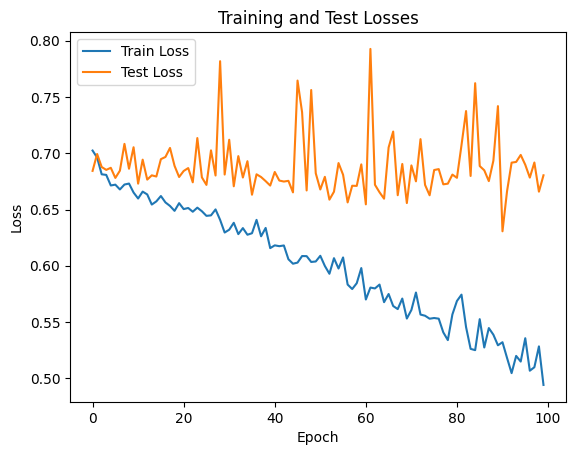

In [57]:
plot_loss(train_losses, test_losses, 100)

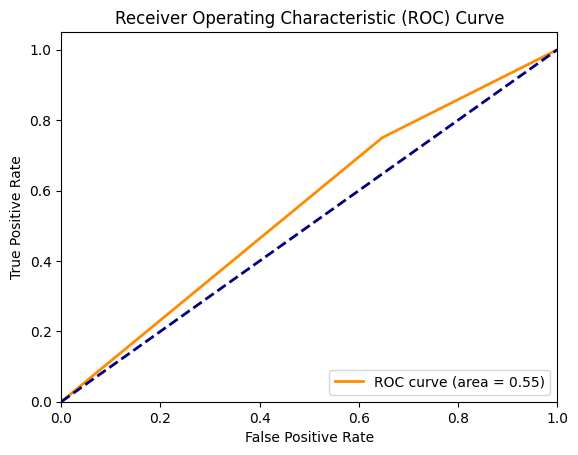

0.5514705882352942
0.6710526315789473
0.75
0.6071428571428571
0.5798319327731093


In [58]:
plot_roc_curve(d["y_true"], d["y_preds"])
roc_auc, f1, recall, precision, accuracy = calculate_metrics(d["y_true"], d["y_preds"])
print(roc_auc,f1,recall,precision,accuracy,sep='\n')